In [1]:
from datasets import load_dataset, Dataset
import sys, os, json
sys.path.append(os.path.join(os.getcwd(), '..'))
from OPRO import OPRO
import pandas as pd
from tqdm.auto import tqdm, trange

opro = OPRO(["gemini", "gemma", "anthropic"])
dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
CHOSEN_PROMPT = dataset["prompts"][4][0]
CHOSEN_PROMPT

'What is the capital of {place}?'

### Original Dataset

In [2]:
original_data = pd.read_csv("country-list.csv")
original_data["country"] = original_data["country"].apply(lambda x: CHOSEN_PROMPT.format(place=x))
original_data.columns = ["question", "answer", "type"]
original_data.head()

,question,answer,type
0,What is the capital of Abkhazia?,Sukhumi,countryCapital
1,What is the capital of Afghanistan?,Kabul,countryCapital
2,What is the capital of Akrotiri and Dhekelia?,Episkopi Cantonment,countryCapital
3,What is the capital of Albania?,Tirana,countryCapital
4,What is the capital of Algeria?,Algiers,countryCapital


### Generating Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers for the prompt: {CHOSEN_PROMPT}.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "question": \"\"\"{question}\"\"\",
    "answer": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step.
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            question=original_data["question"][0],
            answer=original_data["answer"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )
    return eval(response)


if not os.path.exists("synthetic_data.json"):
    qa_pairs = []
    SAMPLE_SIZE = 100

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open("synthetic_data.json", "w") as f:
        f.write(str(qa_pairs))
else:
    # Reading saved data
    with open("synthetic_data.json", "r") as f:
        qa_pairs = eval(f.read())

qa_pairs

[{'question': 'What is the capital of Benin?', 'answer': 'Porto-Novo'},
 {'question': 'What is the capital of Aruba?', 'answer': 'Oranjestad'},
 {'question': 'What is the capital of Togo?', 'answer': 'Lome'},
 {'question': 'What is the capital of Macau SAR?', 'answer': 'Macau'},
 {'question': 'What is the capital of Afghanistan?', 'answer': 'Kabul'},
 {'question': 'What is the capital of Lithuania?', 'answer': 'Vilnius'},
 {'question': 'What is the capital of Italy?', 'answer': 'Rome'},
 {'question': 'What is the capital of Artsakh?', 'answer': 'Stepanakert'},
 {'question': 'What is the capital of Albania?', 'answer': 'Tirana'},
 {'question': 'What is the capital of Armenia?', 'answer': 'Yerevan'},
 {'question': 'What is the capital of Central African Republic?',
  'answer': 'Bangui'},
 {'question': 'What is the capital of Republic of Karelia?',
  'answer': 'Petrozavodsk'},
 {'question': 'What is the capital of Antarctica?', 'answer': 'None'},
 {'question': 'What is the capital of Hond

In [4]:
TRAINING_SAMPLE_SIZE = 30
TESTING_SAMPLE_SIZE = 50

training_sample = Dataset.from_dict(
    {
        "question": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "answer": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "question": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "answer": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["question"]), len(training_sample["answer"]), len(testing_sample["question"]), len(testing_sample["answer"])

(30, 30, 50, 50)

### Optimize Prompt on Synthetic Data

In [5]:
def opt_llm(instruction_score_pairs, training_sample):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    q1, q2, q3 = (
        training_sample["question"][0],
        training_sample["question"][1],
        training_sample["question"][2],
    )
    a1, a2, a3 = (
        training_sample["answer"][0],
        training_sample["answer"][1],
        training_sample["answer"][2],
    )
    response = opro.generate(
        prompt.format(pairs_str=pairs_str, q1=q1, a1=a1, q2=q2, a2=a2, q3=q3, a3=a3),
        model="gemini",  # gemini
        is_indeterministic=True
    )
    return response


def score(instruction, sample):
    """
    Score the instruction using the sample. 
    
    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    prompt = """Q: {question}\nA: {instruction}"""
    with tqdm(sample, desc=instruction, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(question=sample_qa["question"], instruction=instruction),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += opro.similarity(sample_qa["answer"], res)
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [6]:
# Sample 3.5% of the training set
INS_PER_STEP = 8
EXEMPLARS_PER_STEP = 3
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_data_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        "Think step by step.",
        "Take a deep breath and think step-by-step.",
        "Be concise and clear.",
        "You are the creator of an atlas.",
        "Explain your answer in simple terms.",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 0
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            exemplars = training_sample.shuffle()[:EXEMPLARS_PER_STEP]
            instructions = [
                opt_llm(ins_score_pairs, exemplars)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

In [7]:
ins_score_pairs

{'Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends the ordinary.': 53.18300802260637,
 'Compose a stirring tale woven with threads of bravery and self-discovery, igniting the fire of hope within your readers. Paint a vivid canvas with words, capturing the essence of resilience and triumph over adversity. Guide your readers on a transformative journey filled with challenges, growth, and the triumph of the human spirit. Create a narrative that resonates deeply, leaving your readers empowered and inspired to embrace their own extraordinary potential.': 52.5609216466546,
 'Craft a lucid and cogent narrative, captivating your audience through a unique fusion of words that transcends the mundane.': 52.39368757853905,
 "Craft a stirring and evocative narrative that unfolds like a symphony, where each word resonates with the deepest emotions and the prose flows with an elegance that captivates the soul. Paint a world where imaginatio

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

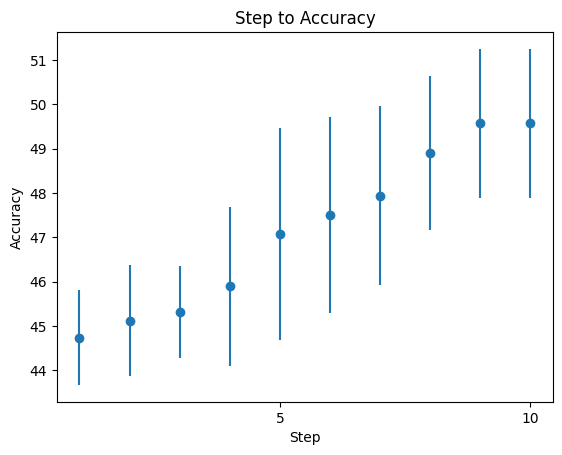

In [8]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [9]:
opro_results[str(len(opro_results))]

{'Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends the ordinary.': 53.18300802260637,
 'Compose a stirring tale woven with threads of bravery and self-discovery, igniting the fire of hope within your readers. Paint a vivid canvas with words, capturing the essence of resilience and triumph over adversity. Guide your readers on a transformative journey filled with challenges, growth, and the triumph of the human spirit. Create a narrative that resonates deeply, leaving your readers empowered and inspired to embrace their own extraordinary potential.': 52.5609216466546,
 'Craft a lucid and cogent narrative, captivating your audience through a unique fusion of words that transcends the mundane.': 52.39368757853905,
 "Craft a stirring and evocative narrative that unfolds like a symphony, where each word resonates with the deepest emotions and the prose flows with an elegance that captivates the soul. Paint a world where imaginatio

In [10]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', testing_sample)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, testing_sample)}")

  0%|          | 0/50 [00:00<?, ?it/s]

No instruction: 48.27450609207153


Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends …

With best instruction (Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends the ordinary.): 54.56144860386849


In [11]:
data_original = Dataset.from_dict(original_data)
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', data_original)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, data_original)}")

  0%|          | 0/248 [00:00<?, ?it/s]

No instruction: 46.87099414426953


Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends …

With best instruction (Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends the ordinary.): 53.533398954858704


In [12]:
prompt = """Q: {question}\nA: {instruction}"""
res = opro.generate(
    prompt.format(question="What is the capital of Argentina?", instruction=best_instruction),
    model="gemma",  # gemma
)
res

'The capital of Argentina is Buenos Aires, a city that pulsates with life and energy. Nestled amidst rolling hills and sparkling waters, Buenos Aires exudes an aura of sophistication and warmth. Its vibrant culture, rich history, and captivating nightlife have made it a magnet for travelers from all corners of the globe.'

In [13]:
opro.similarity("Buenos Aires", res)

0.6017959117889404